# Imagenet Feature Extration

## Setting up environment

In [12]:
import csv
import numpy as np
import matplotlib.pyplot as plt

import cv2
from pathlib import Path
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3

## Getting features by using a pre-trained CNN (InceptionV3 over Imagenet data set)

### PoC Feature Extraction of all training set

First, we need to create an image data generator, to load al the images from the training folder. ImageDataGenerator from Keras, loads the images and give them to the model.

In [8]:
# Image folders
images_folder = 'tiny-imagenet-200'

train_folder = images_folder + '/train'
validation_folder = images_folder + '/val'

# Image dimensions
width = height = 75
channels = 3

# Image pre-processing
batch_size = 128
from_rgb_rescale = 1.0/255

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(rescale=from_rgb_rescale)

train_generator = image_generator.flow_from_directory(
    directory=train_folder, 
    target_size=(width, height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 100000 images belonging to 200 classes.


(75, 75, 3)


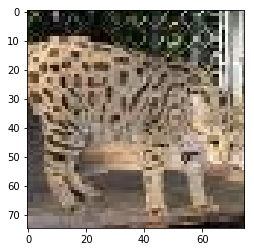

In [28]:
print(train_generator[batch_size-1][1].shape)
plt.imshow(train_generator[batch_size-1][1])

### Extract features

In [29]:
inception_v3_model = InceptionV3(
    include_top=False, 
    weights='imagenet',
    input_shape=image_shape
)

In [30]:
inception_v3_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 37, 37, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 37, 37, 32)   96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 37, 37, 32)   0           batch_normalization_282[0][0]    
__________________________________________________________________________________________________
conv2d_283

In [31]:
inception_v3_model.compile(
    optimizer='adagrad',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [32]:
train_features = inception_v3_model.predict_generator(train_generator)

In [34]:
print('Train features shape {}'.format(train_features.shape))
print('Max {}'.format(train_features.max()))
print('Min {}'.format(train_features.min()))
print('Sample: {}'.format(train_features[0]))

Train features shape (100000, 1, 1, 2048)
Max 26.927715301513672
Min 0.0
Sample: [[[0.7852622  0.         0.41843268 ... 0.         0.         0.        ]]]


### Save features to csv

In [35]:
features_list = [i for i in range(train_features.shape[-1])]

with open('train_tiny_imagenet_features.csv', 'w') as f:
    writer = csv.writer(f)

    writer.writerow(features_list)
    for features in train_features:
        writer.writerow(features[0][0])

## Getting features by using OpenCV methods

In [2]:
import cv2
from pathlib import Path

### Data transformation

First, let's prepare a data structure with data labels and file routes.

In [5]:
def _add_image_labels(image_path):
  label = int(image_path.split('/').pop().split('_')[0][1:])
  return image_path, label


In [9]:
train_path = Path(images_folder + "/train")

class_folders = [class_folder for class_folder in train_path.iterdir()]
image_routes = [str(img) for image_dir in class_folders for img in 
                Path(str(image_dir) + "/images").iterdir()]
labeled_image_routes = list(map(_add_image_labels, image_routes))

### Feature extraction

In [11]:
image_keypoints = {}
bow_kmeans = cv2.BOWKMeansTrainer(10)

In [ ]:
for labeld_image in labeled_image_routes:
  kaze = cv2.KAZE_create()
  image = cv2.imread(labeld_image[0], cv2.IMREAD_COLOR)
  key_points, descriptors = kaze.detectAndCompute(image, None)
  image_keypoints[labeld_image[0]] = key_points
  
  if not descriptors is None and len(descriptors) > 0:
    bow_kmeans.add(descriptors)

In [ ]:
vocabulary = bow_kmeans.cluster()
bow_kmeans.descriptorsCount()

In [ ]:
bow_extractor = cv2.BOWImgDescriptorExtractor(
    cv2.KAZE_create(), 
    cv2.BFMatcher(cv2.NORM_L2)
)
bow_extractor.setVocabulary(vocabulary)

### Saving features from KAZE detection (extracted with BoW)

In [ ]:
features_list = [i for i in range(10)]

with open('kaze_bow_features.csv', 'w') as f:
  writer = csv.writer(f)

  writer.writerow(features_list)
  for labeld_image in labeled_image_routes:
    image = cv2.imread(labeld_image[0])    
    keypoints = image_keypoints[labeld_image[0]]
    
    if not keypoints is None and len(keypoints) > 0:
      histogram = bow_extractor.compute(
          image, 
          keypoints
      )[0]

      writer.writerow(histogram)